In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.model import V1Model
from src.utils import create_stimulus



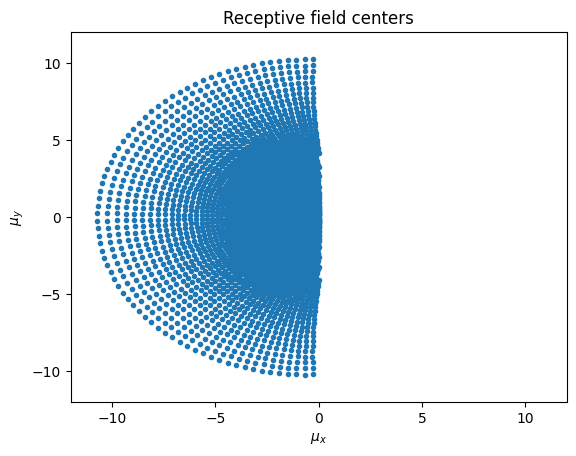

In [2]:
# define V1 model (right hemisphere)
model = V1Model()

# show receptive field centers (left hemifield)
plt.plot(model.mu_x, model.mu_y, '.')
plt.xlim(-12, 12)
plt.ylim(-12, 12)
plt.xlabel('$\\mu_x$')
plt.ylabel('$\\mu_y$')
plt.title('Receptive field centers');


In [3]:
# define visual field coordinates (left hemifield)
r = np.linspace(-16, 0, 100)
X, Y = np.meshgrid(r, r)
X = X.flatten()
Y = -Y.flatten()

# compute Gaussian receptive fields
model.compute_rf(X, Y)

In [4]:
parameters = {
    'center': (-4.95, 4.95),
    'width': 0.17,
    'steps': 18,        # measured in TRs
    'repetitions': 8,
    'pre_rest': 4,      # measured in TRs
    'post_rest': 4,     # measured in TRs
}

# create stimulus
stimulus = create_stimulus(X, Y, parameters)

In [5]:
# compute hemodynamic response
hemodynamic_response = model.compute_response(stimulus)

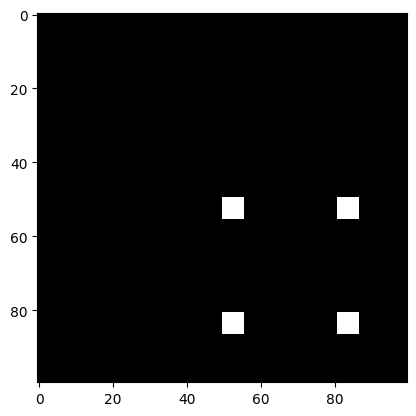

In [6]:
plt.imshow(stimulus[:,6].reshape(100,100), cmap='gray')